# 1D FNO Exercise

In [6]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer
from scipy.io import loadmat

sys.path.append('../')
from models import FNN1d, FNN_train, construct_model, compute_1dFourier_bases
torch.set_printoptions(precision=16)


# Load data

In [7]:
data_path = "../data/burgers_1d/burgers_data_R10.mat"
data = loadmat(data_path)

data size =  2048  mesh elements =  8192


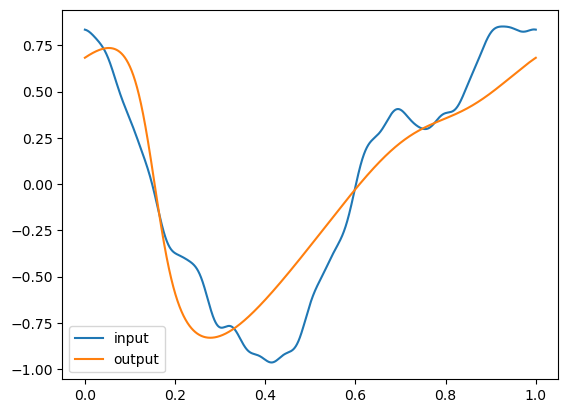

In [8]:
data_in = data["a"]
data_out = data["u"]
print("data size = ", data_in.shape[0], " mesh elements = ", data_in.shape[1])
L = 1 
Ne_ref = data_in.shape[1]
grid = np.linspace(0, L, Ne_ref+1)[:-1]
plt.plot(grid, data_in[0,:], label="input")
plt.plot(grid, data_out[0,:], label="output")
plt.legend()

# 1D Fourier Transform

We compute the Fourier transform for the last dimension of x. We first define the mode set (assume $n_x$ is an even number).

$$K = \{k_x | k_x = 0,1,...,n_x/2-1, -n_x/2, -n_x/2+1, ... -1 \} $$

Then the Fourier transform and inverse Fourier transform give the relation between 
$\{\hat{f}[k_x]: k_x \in K \}$ and $\{f[j_x] : 0 \leq j_x \leq n_x\}$

\begin{align*}
   f(x) &= \frac{1}{n_x} \sum_{k_x \in K}  \hat{f}[k_x]  e^{i k_x \frac{2\pi x}{L_x}} 
   \\ 
   f[j_x] &= \frac{1}{n_x} \sum_{k_x \in K}  \hat{f}[k_x]  e^{i k_x \frac{2\pi j_x \Delta x}{L_x}} 
   \\ 
   \hat{f}[k_x] &= \frac{n_x}{L_x} \int f(x)  e^{-i k_x \frac{2\pi x}{L_x}} dx \\
                &\approx \frac{n_x}{L_x}  \sum_{j_x = 0}^{n_x - 1} f[j_x]  e^{-i k_x \frac{2\pi j_x \Delta x }{L_x}} \Delta x \qquad \textrm{when f has certain form, this is accurate.}\\
                &= \sum_{j_x = 0}^{n_x - 1} f[j_x]  e^{-i k_x \frac{2\pi  j_x}{n_x}}
\end{align*}

When $f(x)$ is real, we have $\hat{f}[k_x] = conj(\hat{f}[-k_x])$, and hence `rfftn` only need to save the subset of $K$ 

$$K^r = \{k_x | k_x = 0,1,...,n_x/2-1, -n_x/2\} $$

For $k_x = 0$ and $-nx/2$, the correponding $\hat{f}[k_x]$ are real numbers. 

When we truncate to first $k_f$ modes, we have 
\begin{align*}
f(x) = \frac{1}{n_x} \Bigl(\hat{f}[0]  \phi_0(x)  +  \sum_{k=1}^{k_f-1}  (\hat{f}[k]  \phi_k(x) + \hat{f}[-k]  \phi_{-k}(x)  )\Bigr)
\end{align*}


In [9]:
# Here is a test, be careful, the torch will generally use float32. 
# To get accurate error estimate, use float64

downsample_ratio = 32
n_train = 2**10
x_train = torch.from_numpy(np.stack((data_in[0:n_train, 0::downsample_ratio], np.tile(grid[0::downsample_ratio], (n_train,1))), axis=-1))
batchsize = 16
x = x_train[0:batchsize]
x = x.permute(0, 2, 1)
x_ft = torch.fft.rfftn(x, dim=[2])
print(" The shape of x is ", x.shape, " the shape of x_ft is ", x_ft.shape)

n_b, n_c, n_x = x.shape
assert(n_x%2 == 0)
n_k = n_x//2

x = x.to(torch.complex128)


# Implementation 1
Kr = list(range(0, n_k)) + [-n_k]
x_ft2 = torch.zeros(n_b, n_c, n_k+1, dtype=torch.complex128)
for j_k in range(n_k+1):
    basis = torch.exp((-Kr[j_k] * 2*np.pi/n_x * 1.0j * torch.linspace(0, n_x-1, n_x, dtype=torch.float64)))  
    x_ft2[:, :, j_k] += torch.einsum('bcx,x->bc', x, basis)
print("Error between x_ft and x_ft2 is ", torch.norm(x_ft - x_ft2))

# Implementation 2
Kr = torch.tensor(list(range(0, n_k)) + [-n_k], dtype=torch.float64)
bases = torch.exp( torch.outer(torch.linspace(0, n_x-1, n_x, dtype=torch.float64), -2*np.pi/n_x * 1.0j * Kr) )  
x_ft2 = torch.einsum('bcx,xk->bck', x, bases)
print("Error between x_ft and x_ft2 is ", torch.norm(x_ft - x_ft2))

 The shape of x is  torch.Size([16, 2, 256])  the shape of x_ft is  torch.Size([16, 2, 129])
Error between x_ft and x_ft2 is  tensor(7.4921795743786390e-12, dtype=torch.float64)
Error between x_ft and x_ft2 is  tensor(7.5010232622467314e-12, dtype=torch.float64)


In [10]:
x_ift = torch.fft.irfftn(x_ft, dim=[2])
print("Error between x and x_ift is ", torch.norm(x - x_ift))

modes = 6
#  Truncate to the first m modes
x_ft_trunc = torch.zeros(n_b, n_c, n_k+1, dtype=torch.complex128)
x_ft_trunc[:, :, :modes] = x_ft[:, :, :modes]

x_ift_trunc = torch.fft.irfftn(x_ft_trunc, dim=[2])

# Implementation 1
Kr = torch.tensor(list(range(0, n_k)) + [-n_k], dtype=torch.float64)
bases = torch.exp( torch.outer(torch.linspace(0, n_x-1, n_x, dtype=torch.float64), 2*np.pi/n_x * 1.0j * Kr) ) 
bases[:,1:-1] *= 2.0
x_ift2 = torch.real(torch.einsum('bck,xk->bcx', x_ft_trunc, bases))/n_x
print("Error between x and x_ift2 is ", torch.norm(x_ift_trunc - x_ift2))

# Implementation 2
Kr = torch.tensor(list(range(0, modes)), dtype=torch.float64)
bases = torch.exp( torch.outer(torch.linspace(0, n_x-1, n_x, dtype=torch.float64), 2*np.pi/n_x * 1.0j * Kr) ) 
bases[:,1:] *= 2.0
x_ift2 = torch.real(torch.einsum('bck,xk->bcx', x_ft_trunc[:, :, :modes], bases))/n_x
print("Error between x and x_ift2 is ", torch.norm(x_ift_trunc - x_ift2))


Error between x and x_ift is  tensor(1.0326249833177797e-14, dtype=torch.float64)
Error between x and x_ift2 is  tensor(1.7990696088728546e-14, dtype=torch.float64)
Error between x and x_ift2 is  tensor(1.7990696088728546e-14, dtype=torch.float64)


# Spectral Transform

We compute the spectral transform for the last dimension of x. 
We first define $n_k$ orthonal bases $\{ \phi_k \}_{k = 0}^{n_k-1}$


Then the spectral transform and inverse spectral transform give the relation between 
$\{\hat{f}[k]: k \in K \}$ and $\{f(x_j) : 0 \leq j \leq n_x\}$

\begin{align*}
   f(x) &= \sum_{k=0}^{n_k-1}  \hat{f}[k]  \phi_k(x) 
   \\ 
   f(x_j) &= \sum_{k_x=0}^{n_k-1}  \hat{f}[k]  \phi_k(x_j)
   \\ 
   \hat{f}[k] &= \int f(x)  \phi_k(x) dx\\
                &= \sum_{j = 0}^{n_x}  f(x_j)  \phi_k(x_j) \Delta x_j
\end{align*}
Here $\phi_k(x)$ are orthogonal bases with $$\int \phi_i(x) \overline{\phi_k(x)} dx = \delta_{ik},$$ and at the discrete level
$$\sum_{j = 0}^{n_x} \phi_i(x_j) \overline{\phi_j(x_j)} \Delta x_j = \delta_{ik}$$



We set bases 
\begin{equation}
B = 
\begin{bmatrix}
\phi_0(x_j)  & \phi_1(x_j)  &  \cdots &  \phi_{n_k-1}(x_j)  
\end{bmatrix}
\end{equation}
and weighted bases 
\begin{equation}
B = 
\begin{bmatrix}
\phi_0(x_j) \Delta x_j  & \phi_1(x_j) \Delta x_j &  \cdots &  \phi_{n_k-1}(x_j) \Delta x_j
\end{bmatrix}
\end{equation}

To recover 1D Fourier Transform, we set 

$$\phi_k(x) = \frac{1}{\sqrt{L_x}},\, \frac{\sqrt{2}}{\sqrt{L_x}}\cos(\frac{2\pi  x}{L_x}), \frac{\sqrt{2}}{\sqrt{L_x}}\sin(\frac{2\pi  x}{L_x}), \cdots \frac{\sqrt{2}}{\sqrt{L_x}}\cos(\frac{2k\pi x}{L_x}), \frac{\sqrt{2}}{\sqrt{L_x}}\sin(\frac{2k\pi x}{L_x}),\cdots $$



In [13]:
torch.manual_seed(0)
np.random.seed(0)

downsample_ratio = 16

L = 1.0
Ne_ref = data_in.shape[1]
grid = np.linspace(0, L, Ne_ref+1)[:-1]

n_train = n_test = 2**10
x_train = torch.from_numpy(np.stack((data_in[0:n_train, 0::downsample_ratio], np.tile(grid[0::downsample_ratio], (n_train,1))), axis=-1).astype(np.float32))
y_train = torch.from_numpy(data_out[0:n_train, 0::downsample_ratio, np.newaxis].astype(np.float32))
# x_train, y_train are [n_data, n_x, n_channel] arrays
x_test = torch.from_numpy(np.stack((data_in[-n_test:, 0::downsample_ratio], np.tile(grid[0::downsample_ratio], (n_train,1))), axis=-1).astype(np.float32))
y_test = torch.from_numpy(data_out[-n_test:, 0::downsample_ratio, np.newaxis].astype(np.float32))
# x_test, y_test are [n_data, n_x, n_channel] arrays







n_fno_layers = 3
k_max =  33 #16
d_f = 128
# fourier k_max
modes = [k_max] * n_fno_layers
# channel d_f
layers = [d_f] * (n_fno_layers + 1)
fc_dim = d_f
in_dim = 2
out_dim = 1
act = "gelu"

epochs = 1000
base_lr = 0.001


milestones = [200, 300, 400, 500, 800, 900]
scheduler_gamma = 0.5

scheduler = "MultiStepLR"
weight_decay = 1.0e-4
# batch_size=32
dim = 1

# scheduler = "CosineAnnealingLR"
# weight_decay = 1.0e-4
batch_size=64

normalization_x = True
normalization_y = True
normalization_dim = []
pad_ratio = 0.05


basis_type = "Galerkin_bases"

if basis_type == "Fast_Fourier_Transform":
    
     
    k_max =  k_max//2 #16
    modes = [k_max] * n_fno_layers
    
    bases = None
    wbases = None
    model_type = "FNO"
    
elif basis_type == "Fourier_bases":
    
    
    Ne = Ne_ref//downsample_ratio
    grid, fbases, weights = compute_1dFourier_bases(Ne, k_max, L)
    wfbases = fbases*np.tile(weights, (k_max,1)).T
    bases = [torch.from_numpy(fbases.astype(np.float32))]
    wbases = [torch.from_numpy(wfbases.astype(np.float32))]
    model_type = "GalerkinNO"
    
elif basis_type == "Galerkin_bases":
    
    Ne = Ne_ref//downsample_ratio

    pca_data = data_out[0:n_train, 0::downsample_ratio]
    pca_include_input = False
    pca_include_grid = False
    if pca_include_input:
        pca_data = np.vstack((pca_data, data_in[0:n_train, 0::downsample_ratio]))
    if pca_include_grid:
        n_grid = 1
        pca_data = np.vstack((pca_data, np.tile(grid[0::downsample_ratio], (n_grid,1))))
    
    U,S,VT = np.linalg.svd(pca_data.T)
    # the integration of the basis is 1.
    fbases = U[:, 0:k_max] / np.sqrt(L/Ne)
    wfbases = L/Ne * fbases
    bases = [torch.from_numpy(fbases.astype(np.float32))]
    wbases = [torch.from_numpy(wfbases.astype(np.float32))]
    model_type = "GalerkinNO"
    
else:
    
    print("Bases construction error")

config = {"model" : {"model": model_type, "dim": dim, "modes": modes, "fc_dim": fc_dim, "layers": layers, "in_dim": in_dim, "out_dim":out_dim, "act": act, "pad_ratio":pad_ratio},
          "train" : {"base_lr": base_lr, "weight_decay": weight_decay, "epochs": epochs, "scheduler": scheduler, "milestones": milestones, "scheduler_gamma": scheduler_gamma, "batch_size": batch_size, 
          
                     "normalization_x": normalization_x,"normalization_y": normalization_y, "normalization_dim": normalization_dim}}


model =  construct_model(config, bases, wbases)
    

In [14]:
print("Start training ", config["model"]["model"]) 
train_rel_l2_losses, test_rel_l2_losses, test_l2_losses, cost = FNN_train(x_train, y_train, x_test, y_test, config, model,  save_model_name="models/test")

Start training  GalerkinNO
Epoch :  0  Rel. Train L2 Loss :  0.5266668889671564  Rel. Test L2 Loss :  0.3536986690014601  Test L2 Loss :  0.16257141344249249


KeyboardInterrupt: 

In [ ]:
Start training  GalerkinNO
Epoch :  0  Rel. Train L2 Loss :  0.5530278962105513  Rel. Test L2 Loss :  0.3639783691614866  Test L2 Loss :  0.16688358411192894
Epoch :  10  Rel. Train L2 Loss :  0.05540479300543666  Rel. Test L2 Loss :  0.06010106788016856  Test L2 Loss :  0.027525703771971166
Epoch :  20  Rel. Train L2 Loss :  0.02729798946529627  Rel. Test L2 Loss :  0.030181090580299497  Test L2 Loss :  0.014549962885212153
Epoch :  30  Rel. Train L2 Loss :  0.023524480871856213  Rel. Test L2 Loss :  0.02733145747333765  Test L2 Loss :  0.012954483041539788
Epoch :  40  Rel. Train L2 Loss :  0.03390151506755501  Rel. Test L2 Loss :  0.032641293248161674  Test L2 Loss :  0.014019099180586636
Epoch :  50  Rel. Train L2 Loss :  0.028370561194606125  Rel. Test L2 Loss :  0.02992247836664319  Test L2 Loss :  0.013746349257417023
Epoch :  60  Rel. Train L2 Loss :  0.016377027553971857  Rel. Test L2 Loss :  0.02047357289120555  Test L2 Loss :  0.009557288809446618
Epoch :  70  Rel. Train L2 Loss :  0.016247911378741264  Rel. Test L2 Loss :  0.0221169067081064  Test L2 Loss :  0.009881779027637094
Epoch :  80  Rel. Train L2 Loss :  0.018533223308622837  Rel. Test L2 Loss :  0.019773047999478877  Test L2 Loss :  0.009210543415974826
Epoch :  90  Rel. Train L2 Loss :  0.014880945847835392  Rel. Test L2 Loss :  0.0222996415104717  Test L2 Loss :  0.01034952379995957
Epoch :  100  Rel. Train L2 Loss :  0.023593697929754853  Rel. Test L2 Loss :  0.026125550735741854  Test L2 Loss :  0.012204635073430836
Epoch :  110  Rel. Train L2 Loss :  0.0163455773727037  Rel. Test L2 Loss :  0.019539905828423798  Test L2 Loss :  0.009263549611205235
Epoch :  120  Rel. Train L2 Loss :  0.012967587856110185  Rel. Test L2 Loss :  0.020988903241232038  Test L2 Loss :  0.009709200297947973
Epoch :  130  Rel. Train L2 Loss :  0.014892612001858652  Rel. Test L2 Loss :  0.021787052624858916  Test L2 Loss :  0.009926729835569859
Epoch :  140  Rel. Train L2 Loss :  0.022582464618608356  Rel. Test L2 Loss :  0.03254837263375521  Test L2 Loss :  0.014737804944161326
Epoch :  150  Rel. Train L2 Loss :  0.017551998258568347  Rel. Test L2 Loss :  0.01922531088348478  Test L2 Loss :  0.008974029566161335
Epoch :  160  Rel. Train L2 Loss :  0.01702975877560675  Rel. Test L2 Loss :  0.01916457514744252  Test L2 Loss :  0.00896387847024016
Epoch :  170  Rel. Train L2 Loss :  0.01095853850711137  Rel. Test L2 Loss :  0.011898183031007648  Test L2 Loss :  0.005927028658334166
Epoch :  180  Rel. Train L2 Loss :  0.01998165505938232  Rel. Test L2 Loss :  0.026575087918899953  Test L2 Loss :  0.012266059755347669
Epoch :  190  Rel. Train L2 Loss :  0.010873873543459922  Rel. Test L2 Loss :  0.014671170676592737  Test L2 Loss :  0.007119098474504426
Epoch :  200  Rel. Train L2 Loss :  0.01028971589403227  Rel. Test L2 Loss :  0.013454765372443944  Test L2 Loss :  0.006566085590748116
Epoch :  210  Rel. Train L2 Loss :  0.006467006693128496  Rel. Test L2 Loss :  0.011402946896851063  Test L2 Loss :  0.0056951247388496995
Epoch :  220  Rel. Train L2 Loss :  0.007936486625112593  Rel. Test L2 Loss :  0.010351956530939788  Test L2 Loss :  0.005171463039005175
Epoch :  230  Rel. Train L2 Loss :  0.005818177392939106  Rel. Test L2 Loss :  0.009853201336227357  Test L2 Loss :  0.005036661037593149
Epoch :  240  Rel. Train L2 Loss :  0.011104872624855489  Rel. Test L2 Loss :  0.01421331736491993  Test L2 Loss :  0.006690551701467484
Epoch :  250  Rel. Train L2 Loss :  0.007700835034484044  Rel. Test L2 Loss :  0.010917078296188265  Test L2 Loss :  0.005546584783587605
Epoch :  260  Rel. Train L2 Loss :  0.0068678474926855415  Rel. Test L2 Loss :  0.011556127166841179  Test L2 Loss :  0.005775771656772122
Epoch :  270  Rel. Train L2 Loss :  0.006902240013005212  Rel. Test L2 Loss :  0.011474454251583666  Test L2 Loss :  0.005823984072776511
Epoch :  280  Rel. Train L2 Loss :  0.007895537943113595  Rel. Test L2 Loss :  0.011459440807811916  Test L2 Loss :  0.005707353935576975
Epoch :  290  Rel. Train L2 Loss :  0.007066981052048504  Rel. Test L2 Loss :  0.012559539813082665  Test L2 Loss :  0.0060487362497951835
Epoch :  300  Rel. Train L2 Loss :  0.007625468191690743  Rel. Test L2 Loss :  0.009424212155863643  Test L2 Loss :  0.004864282789640129
Epoch :  310  Rel. Train L2 Loss :  0.0034248315932927653  Rel. Test L2 Loss :  0.008168773783836514  Test L2 Loss :  0.004320120162446983
Epoch :  320  Rel. Train L2 Loss :  0.0033389161253580824  Rel. Test L2 Loss :  0.008337368431966752  Test L2 Loss :  0.0043621797958621755
Epoch :  330  Rel. Train L2 Loss :  0.0035498587385518476  Rel. Test L2 Loss :  0.008126365311909467  Test L2 Loss :  0.004305309703340754
Epoch :  340  Rel. Train L2 Loss :  0.0035115051723551005  Rel. Test L2 Loss :  0.008424282394116744  Test L2 Loss :  0.004376467477413826
Epoch :  350  Rel. Train L2 Loss :  0.0035720229643629864  Rel. Test L2 Loss :  0.008311846031574532  Test L2 Loss :  0.004340929983300157
Epoch :  360  Rel. Train L2 Loss :  0.0037024067278252915  Rel. Test L2 Loss :  0.008369034912902862  Test L2 Loss :  0.004366784778540023
Epoch :  370  Rel. Train L2 Loss :  0.003762367312447168  Rel. Test L2 Loss :  0.008014965802431107  Test L2 Loss :  0.00422419115784578
Epoch :  380  Rel. Train L2 Loss :  0.005504093074705452  Rel. Test L2 Loss :  0.011670866864733398  Test L2 Loss :  0.0056989417935255915
Epoch :  390  Rel. Train L2 Loss :  0.0038136375951580703  Rel. Test L2 Loss :  0.008301144553115591  Test L2 Loss :  0.004283903515897691

In [ ]:
Fourier bases

Epoch :  0  Rel. Train L2 Loss :  0.5343242827802896  Rel. Test L2 Loss :  0.35652035661041737  Test L2 Loss :  0.16434418968856335
Epoch :  10  Rel. Train L2 Loss :  0.05252824304625392  Rel. Test L2 Loss :  0.08707353239879012  Test L2 Loss :  0.038476263638585806
Epoch :  20  Rel. Train L2 Loss :  0.03379512997344136  Rel. Test L2 Loss :  0.034905026433989406  Test L2 Loss :  0.016287033446133137
Epoch :  30  Rel. Train L2 Loss :  0.03300807299092412  Rel. Test L2 Loss :  0.035803209990262985  Test L2 Loss :  0.0160839143791236
Epoch :  40  Rel. Train L2 Loss :  0.02496281557250768  Rel. Test L2 Loss :  0.031191959278658032  Test L2 Loss :  0.01455920428270474
Epoch :  50  Rel. Train L2 Loss :  0.019304369459860027  Rel. Test L2 Loss :  0.025718713994137943  Test L2 Loss :  0.01162591646425426
Epoch :  60  Rel. Train L2 Loss :  0.019517153152264655  Rel. Test L2 Loss :  0.022306667640805244  Test L2 Loss :  0.010376633668784052
Epoch :  70  Rel. Train L2 Loss :  0.02815706399269402  Rel. Test L2 Loss :  0.024218744249083102  Test L2 Loss :  0.011378672847058624
Epoch :  80  Rel. Train L2 Loss :  0.01887817436363548  Rel. Test L2 Loss :  0.02192652691155672  Test L2 Loss :  0.01027321710716933
Epoch :  90  Rel. Train L2 Loss :  0.01543609204236418  Rel. Test L2 Loss :  0.027948095579631627  Test L2 Loss :  0.012622756243217736
Epoch :  100  Rel. Train L2 Loss :  0.018864598590880632  Rel. Test L2 Loss :  0.022070111241191626  Test L2 Loss :  0.010092632728628814
Epoch :  110  Rel. Train L2 Loss :  0.01430836075451225  Rel. Test L2 Loss :  0.022063812939450145  Test L2 Loss :  0.010145931446459144
Epoch :  120  Rel. Train L2 Loss :  0.025544452480971813  Rel. Test L2 Loss :  0.027506385231390595  Test L2 Loss :  0.012613549712114036

In [ ]:
FNO


Epoch :  0  Rel. Train L2 Loss :  0.46048319712281227  Rel. Test L2 Loss :  0.21462657395750284  Test L2 Loss :  0.10189483733847737
Epoch :  10  Rel. Train L2 Loss :  0.027924850466661155  Rel. Test L2 Loss :  0.07714566262438893  Test L2 Loss :  0.034094139584340155
Epoch :  20  Rel. Train L2 Loss :  0.018535724841058254  Rel. Test L2 Loss :  0.015555003948975354  Test L2 Loss :  0.007413918210659176
Epoch :  30  Rel. Train L2 Loss :  0.033206918742507696  Rel. Test L2 Loss :  0.03395757800899446  Test L2 Loss :  0.013370171596761793
Epoch :  40  Rel. Train L2 Loss :  0.027009477373212576  Rel. Test L2 Loss :  0.034347848035395145  Test L2 Loss :  0.01633133686846122
Epoch :  50  Rel. Train L2 Loss :  0.027066212380304933  Rel. Test L2 Loss :  0.028407053323462605  Test L2 Loss :  0.012727975437883288
Epoch :  60  Rel. Train L2 Loss :  0.024569524568505585  Rel. Test L2 Loss :  0.01891404762864113  Test L2 Loss :  0.00866693290299736
Epoch :  70  Rel. Train L2 Loss :  0.023619975079782307  Rel. Test L2 Loss :  0.02239359519444406  Test L2 Loss :  0.009641381271649152
Epoch :  80  Rel. Train L2 Loss :  0.012316441512666643  Rel. Test L2 Loss :  0.011593313072808087  Test L2 Loss :  0.0054851210152264684
Epoch :  90  Rel. Train L2 Loss :  0.022688035969622433  Rel. Test L2 Loss :  0.01963267824612558  Test L2 Loss :  0.008665522997034714
Epoch :  100  Rel. Train L2 Loss :  0.014114718767814338  Rel. Test L2 Loss :  0.015954271773807704  Test L2 Loss :  0.006967136519961059